In [3]:
import json
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import datetime

# Importing data from JSON 

Link to dataset: https://data.cityofchicago.org/Service-Requests/311-Service-Requests-Pot-Holes-Reported/7as2-ds3y

In [5]:
with open('data/311_requests.json', encoding='utf-8') as data_file:
    data = json.loads(data_file.read())

#Retrieve column headings from metadata JSON 
columnHeadings = []
for d in data['meta']['view']['columns']:
    if 'flags' not in d.keys():
        columnHeadings.append(d['name'])
columnHeadings = columnHeadings[0:len(columnHeadings) - 1]

#Gather data rows into list and removing unnecessary initial columns
rows = data['data']
dataset = []
for row in rows:
    new_row = row[8:len(row)-1]
    dataset.append(new_row)

#Convert to panda DataFrame
dfOriginal = pd.DataFrame(dataset)
dfOriginal.columns = columnHeadings

# Cleaning the dataset

In [6]:
df = dfOriginal.copy()

#Convert completion date from string to datetime object
cleanedCompletionDate = []
for date in df['COMPLETION DATE']:
    if date != None:
        cleanedCompletionDate.append(datetime.datetime.strptime(date, '%Y-%m-%dT%H:%M:%S'))
    else:
        cleanedCompletionDate.append(None)
df.insert(3, 'cleaned Completion Date', cleanedCompletionDate)

#Convert creation date from string to datetime object
cleanedCreationDate = []
for date in df['CREATION DATE']:
    if date != None:
        cleanedCreationDate.append(datetime.datetime.strptime(date, '%Y-%m-%dT%H:%M:%S'))
    else:
        cleanedCreationDate.append(None)
df.insert(1, 'cleaned Creation Date', cleanedCreationDate)

#Convert 'Number of Potholes Filled on Block' to integers and latitude, longitude, x & y coordinates to floats
df.insert(10, 'Num Potholes Filled On Block', pd.to_numeric(df['NUMBER OF POTHOLES FILLED ON BLOCK'], errors = 'ignore', downcast = 'integer'))
df.insert(11, 'X Coordinate', pd.to_numeric(df['X COORDINATE']).fillna(''))
df.insert(12, 'Y Coordinate', pd.to_numeric(df['Y COORDINATE']).fillna(''))
df.insert(13, 'Latitude', pd.to_numeric(df['LATITUDE']).fillna(''))
df.insert(14, 'Longitude', pd.to_numeric(df['LONGITUDE']).fillna(''))

#Delete original columns containing uncleaned data
del df['CREATION DATE'], df['COMPLETION DATE'], df['NUMBER OF POTHOLES FILLED ON BLOCK'], df['X COORDINATE'], df['Y COORDINATE'], df['LATITUDE'], df['LONGITUDE']

df

,cleaned Creation Date,STATUS,cleaned Completion Date,SERVICE REQUEST NUMBER,TYPE OF SERVICE REQUEST,CURRENT ACTIVITY,MOST RECENT ACTION,Num Potholes Filled On Block,X Coordinate,Y Coordinate,Latitude,Longitude,STREET ADDRESS,ZIP,Ward,Police District,Community Area,SSA
0,2011-01-01,Completed - Dup,2011-01-03,11-00002110,Pot Hole in Street,None,None,NaN,1.17386e+06,1.85451e+06,41.7561,-87.6385,7600 S PARNELL AVE,60620,17,6,69,None
1,2011-01-01,Completed - Dup,2011-01-03,11-00002209,Pot Hole in Street,None,None,NaN,1.15093e+06,1.85722e+06,41.764,-87.7225,7100 S PULASKI RD,60629,13,8,65,3
2,2011-01-01,Completed - Dup,2011-01-03,11-00002224,Pot Hole in Street,None,None,NaN,1.15996e+06,1.91589e+06,41.925,-87.6877,2400 W FULLERTON AVE,60647,1,14,22,None
3,2011-01-01,Completed - Dup,2011-01-03,11-00002247,Pot Hole in Street,None,None,NaN,1.17296e+06,1.83124e+06,41.6923,-87.6425,11100 S HALSTED ST,60628,34,22,75,45
4,2011-01-01,Completed - Dup,2011-01-03,11-00002276,Pot Hole in Street,None,None,NaN,1.1757e+06,1.89504e+06,41.8673,-87.6306,1200 S CLARK ST,60605,2,1,33,None
5,2011-01-01,Completed - Dup,2011-01-03,11-00002947,Pot Hole in Street,None,None,NaN,1.17533e+06,1.91646e+06,41.9262,-87.6313,2400 N NB OUTER LAKE SHORE DR,60614,43,23,7,None
6,2011-01-01,Completed - Dup,2011-01-03,11-00003041,Pot Hole in Street,None,None,NaN,1.16694e+06,1.91077e+06,41.9107,-87.6623,1600 N ELSTON AVE,60642,32,14,24,None
7,2011-01-01,Completed - Dup,2011-01-03,11-00003086,Pot Hole in Street,None,None,NaN,1.15093e+06,1.85722e+06,41.764,-87.7225,7100 S PULASKI RD,60629,13,8,65,3
8,2011-01-01,Completed - Dup,2011-01-03,11-00003439,Pot Hole in Street,None,None,NaN,1.16914e+06,1.92283e+06,41.9438,-87.654,3408 N CLARK ST,60657,44,19,6,17
9,2011-01-01,Completed,2011-01-03,11-00002021,Pot Hole in Street,Dispatch Crew,Pothole Patched,5.0,1.16695e+06,1.83906e+06,41.714,-87.6651,1642 W 99TH ST,60643,19,22,72,None


In [7]:
#Remove any data pertaining to Ward 0
df = df[df.Ward != '0']

# Data Exploration

To begin digging into the data, we will first need to classify the wards.  Chicago's wards are not numbered according to any logic and it can be difficult to understand their location without poring over a map.  We will create a Ward column and add a "direction" to define if the ward is located on the north or south side of the city.

While each neighborhood in Chicago has defining characteristics, the difference between the North and South side of the city has long been the historic dividing point between affluence and poverty, between residences and industry.  I defined Chicago's "Mason-Dixon Line" as I-290 to roughly divide the city between the North Side and South Side.  Ward 42 will be defined as "Central" as this ward contains the Loop, Chicago's main business district, and is considered "downtown".  

Later in the analysis, we will pull in census data to further refine these assumptions and understand each ward's median salary, home price, etc. but for initial data exploration, the north-south division will provide some insights.

In [8]:
wards = {'17':'south', '42':'central', '41':'north', '39':'north', '50':'north', '49':'north', '48':'north', '40':'north', '45': 'north', '38': 'north', '36': 'north', '30': 'north', '35': 'north', '33':'north', '47': 'north', '48': 'north', '46': 'north', '44': 'north', '32': 'north', '31': 'north', '36': 'north', '29': 'north', '37': 'north', '26': 'north', '1': 'north', '2': 'north', '43': 'north', '28': 'north', '27': 'north', '24':'south', '25': 'south', '22': 'south', '12':'south', '11': 'south', '4': 'south', '3': 'south', '14': 'south', '15': 'south', '23': 'south', '13': 'south', '17': 'south', '16': 'south', '20': 'south', '5': 'south', '18': 'south', '6': 'south', '21': 'south', '8': 'south', '7': 'south', '19': 'south', '34': 'south', '9': 'south', '10': 'south'}

In [9]:
#Checking that all wards are included and none are repeated.
all_k = []
s = 0

for k in wards.keys():
    if k not in all_k:
        s += 1
        all_k.append(k)
    else:
        print(k)
s

50

In [10]:
dfWards = pd.Series(wards).reset_index()
dfWards.columns = ['Ward', 'Direction']
df = pd.merge(df, dfWards, on='Ward')

### Average wait time for pothole repair by ward

First, let's test the City's statement that "Pothole repairs are generally completed within 7 days from the first report of a pothole to 311."

In [11]:
df['timePassed'] = (df['cleaned Completion Date'] - df['cleaned Creation Date']).dt.days

weekOrLess = df[df['timePassed'] < 7]

#Count by creation date to find all requests
pctWeekOrLess = weekOrLess['cleaned Creation Date'].count() * 100 / df['cleaned Creation Date'].count()
pctWeekOrLess

45.797507781614584

Almost 46% of all pothole requests are completed within 7 days.  How does the number of days that elapse between service request and completion vary depending on the ward in which the pothole is located?

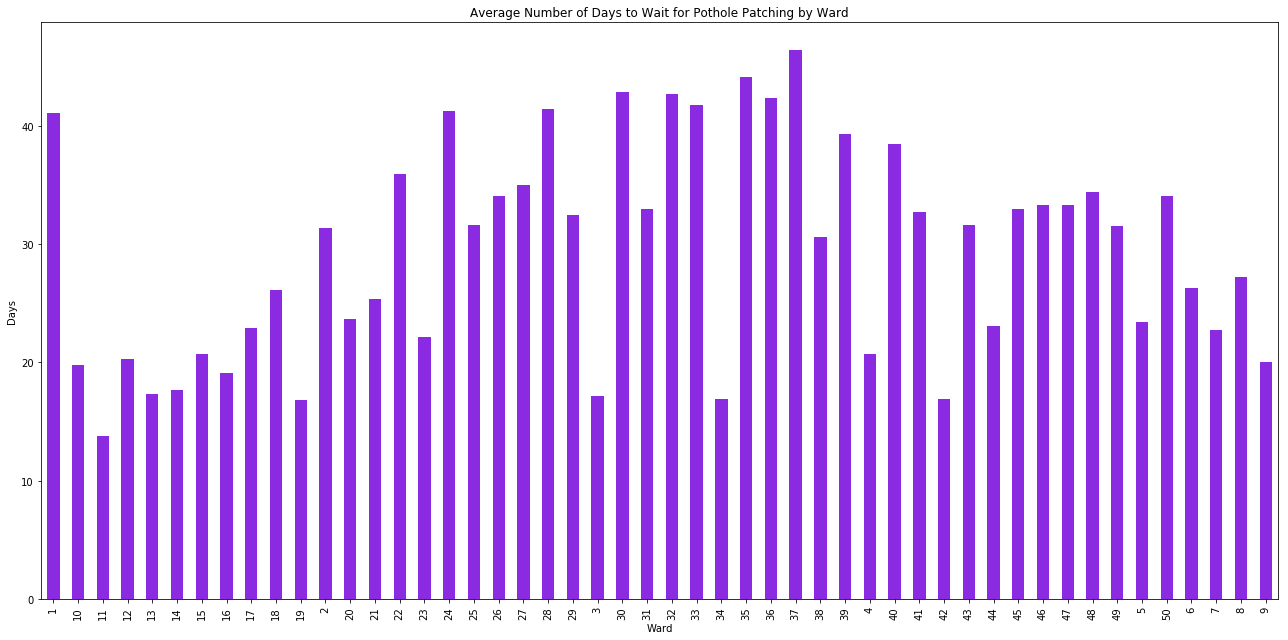

In [12]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

#Produce a bar chart of the average number of days between service request and completion by ward
avgDays = df.groupby(['Ward', 'Direction'])['timePassed'].mean()

fig = plt.figure(figsize=(18, 9))
avgDays.plot(kind='bar', color = 'blueviolet');
ax = plt.gca()
ax.set_xticklabels(avgDays.index.levels[0])
plt.xlabel('Ward')
plt.ylabel('Days');
plt.title('Average Number of Days to Wait for Pothole Patching by Ward');

fig.tight_layout()

From looking at the graph, we notice a few wards (ex. 11, 19, 3, 34, 42) seem to have a shorter average wait.  Let's analyze by finding all wards where the average wait time is less than 20 days.

In [13]:
avgDays[avgDays < 20]

Ward  Direction
10    south        19.750642
11    south        13.799250
13    south        17.315562
14    south        17.695027
16    south        19.120258
19    south        16.817314
3     south        17.128105
34    south        16.932527
42    central      16.906936
Name: timePassed, dtype: float64

Out of the nine wards with a wait time of less than 20 days, eight are located on the south side in typically more industrial areas of the city.  The ninth ward (42) on the list includes the Loop, Chicago's business district, and is most likely a priority for the Department of Transportation on pothole patching.  We'll break down wait time by season next but first we'll look at the longest wait time for pothole repair.

In [14]:
avgDays[avgDays > 40]

Ward  Direction
1     north        41.115450
24    south        41.228075
28    north        41.418774
30    north        42.873274
32    north        42.721124
33    north        41.765102
35    north        44.120968
36    north        42.327989
37    north        46.431747
Name: timePassed, dtype: float64

All of the wards with a wait time of longer than 40 years are on the north side of the city, except for Ward 24 which is just south of I-290.

### Average wait time for pothole repair by season

Let's see how response time varies by the season in which the request was created.

In [15]:
#Create seasons by clustering months
spring = [3, 4, 5]
summer = [6, 7, 8]
fall = [9, 10, 11]
winter = [12, 1, 2]

#Initialize season list
seasons = []

#Run through creation dates in dataframe and append correct season to list
for date in df['cleaned Creation Date']:
    if date.month in winter:
        seasons.append('winter')
    elif date.month in fall:
        seasons.append('fall')
    elif date.month in spring:
        seasons.append('spring')
    elif date.month in summer:
        seasons.append('summer')

#Add seasons as a column in dataframe
df['season'] = seasons

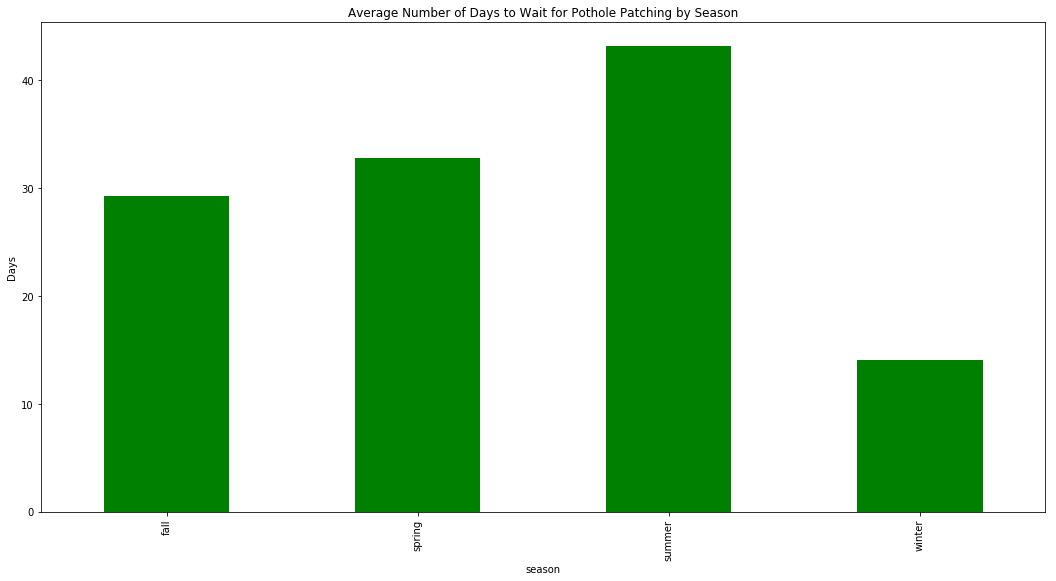

In [16]:
avgDaysBySeason = df.groupby('season')['timePassed'].mean()

fig = plt.figure(figsize=(18, 9))
avgDaysBySeason.plot(kind='bar', color = 'g')
plt.ylabel('Days');
plt.title('Average Number of Days to Wait for Pothole Patching by Season');

Interestingly, even though the City claims that frigid temperatures can delay pothole repairs, we find that summer results in the longest wait while winter has the shortest.  We'll pull in weather data to see how temperature and precipitation specifically affects response time later in this analysis.  Did Chicago have unusually mild winters over the past six years?  Have the summers been too rainy to patch potholes?

Another point to consider is that pothole frequency generally increases in the winter due to the freeze/thaw cycle.  We will look at the number of pothole reports by both ward and season next.  First, we'll look at how response time by ward changes with each season.

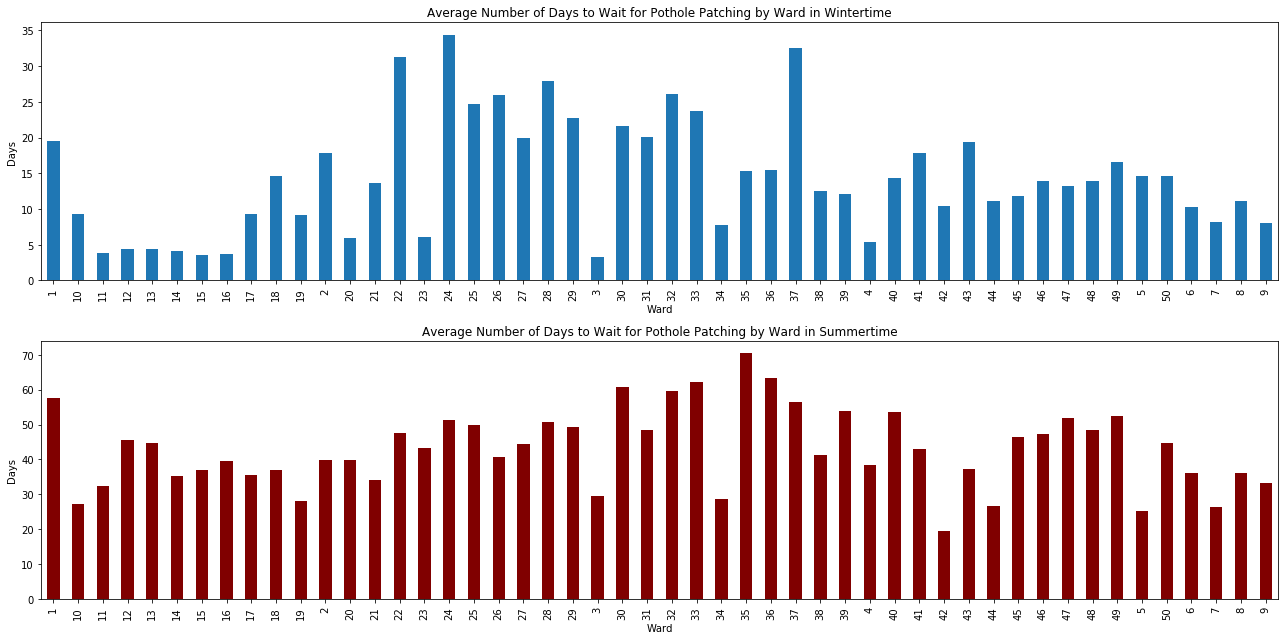

In [17]:
avgDaysSeasonWard = df.groupby(['season', 'Ward', 'Direction'])['timePassed'].mean()

#We'll only look at winter and summer as the two extreme seasons
fig = plt.figure(figsize=(18, 9))
plt.subplot(2, 1, 1)
avgDaysSeasonWard['winter'].plot(kind = 'bar')
ax = plt.gca()
ax.set_xticklabels(avgDays.index.levels[0])
plt.xlabel('Ward')
plt.ylabel('Days');
plt.title('Average Number of Days to Wait for Pothole Patching by Ward in Wintertime');

plt.subplot(2, 1, 2)
avgDaysSeasonWard['summer'].plot(kind = 'bar', color = 'maroon')
ax = plt.gca()
ax.set_xticklabels(avgDays.index.levels[0])
plt.xlabel('Ward')
plt.ylabel('Days');
plt.title('Average Number of Days to Wait for Pothole Patching by Ward in Summertime');

fig.tight_layout()

We see more extreme differences by ward for response time in the winter.  Let's take another look at which wards show the longest and shortest response time for winter and summer.

In [18]:
print('Wards with Wait Time less than 20 days in Summertime')
print(avgDaysSeasonWard['summer'][avgDaysSeasonWard['summer'] < 20].to_string(header=None, index=True))
print('')
print ('Wards with Wait Time more than 40 days in Summertime')
print(avgDaysSeasonWard['summer'][avgDaysSeasonWard['summer'] > 40].to_string(header=None, index=True))

Wards with Wait Time less than 20 days in Summertime
42    central      19.571019

Wards with Wait Time more than 40 days in Summertime
1     north        57.607352
12    south        45.519718
13    south        44.670494
22    south        47.686809
23    south        43.344436
24    south        51.238730
25    south        49.968727
26    north        40.583276
27    north        44.331754
28    north        50.856821
29    north        49.417750
30    north        60.806760
31    north        48.383298
32    north        59.522438
33    north        62.338451
35    north        70.423559
36    north        63.374590
37    north        56.593413
38    north        41.187674
39    north        53.920847
40    north        53.490771
41    north        43.129578
45    north        46.307039
46    north        47.299639
47    north        51.902990
48    north        48.356582
49    north        52.467814
50    north        44.583909


Only Ward 42 makes a return appearance on the list for an average wait time of less than 20 days.  Twenty-eight wards (more than half the city) have wait times of greater than 40 days in the summer, mostly on the north side but several southern wards also appear on the list.  Let's look at wait times in the winter to compare.

In [19]:
print('Wards with Wait Time less than 20 days in Wintertime')
print(avgDaysSeasonWard['winter'][avgDaysSeasonWard['winter'] < 20].to_string(header=None, index=True))
print('')
print ('Wards with Wait Time more than 40 days in Wintertime')
print(avgDaysSeasonWard['winter'][avgDaysSeasonWard['winter'] > 40].to_string(header=None, index=True))

Wards with Wait Time less than 20 days in Wintertime
1     north        19.515707
10    south         9.302447
11    south         3.800199
12    south         4.447460
13    south         4.456586
14    south         4.175459
15    south         3.580260
16    south         3.727818
17    south         9.333600
18    south        14.572378
19    south         9.132971
2     north        17.880034
20    south         5.943979
21    south        13.580915
23    south         6.053109
27    north        19.905270
3     south         3.288341
34    south         7.769661
35    north        15.255579
36    north        15.427017
38    north        12.484314
39    north        12.144597
4     south         5.370482
40    north        14.315768
41    north        17.845634
42    central      10.434028
43    north        19.320951
44    north        11.134319
45    north        11.750754
46    north        13.984772
47    north        13.287988
48    north        13.895568
49    north        

A total of 39 wards have average wait times of less than 20 days--none have an average wait time above 40 days.  Can each ward expect a faster response time in the winter compared to the summer?

In [20]:
#Create panda series for average wait times by ward in both summer and winter.
summer = pd.Series(avgDaysSeasonWard['summer'], name= 'summer wait')
winter = pd.Series(avgDaysSeasonWard['winter'], name = 'winter wait')

#Combine into one dataframe to find if any average winter wait times are longer than average ummer wait times.
seasonalWait = pd.concat([winter, summer], axis=1)
seasonalWait[seasonalWait['winter wait'] >= seasonalWait['summer wait']]

,,winter wait,summer wait
Ward,Direction,,


Not a single ward was returned when we searched for a longer average wait time in the summer vs. the winter.  Chicago residents can conclude that reporting a pothole in the winter will result in a faster response from the City.

### Pothole reports by ward and season

How often are potholes reported by ward?

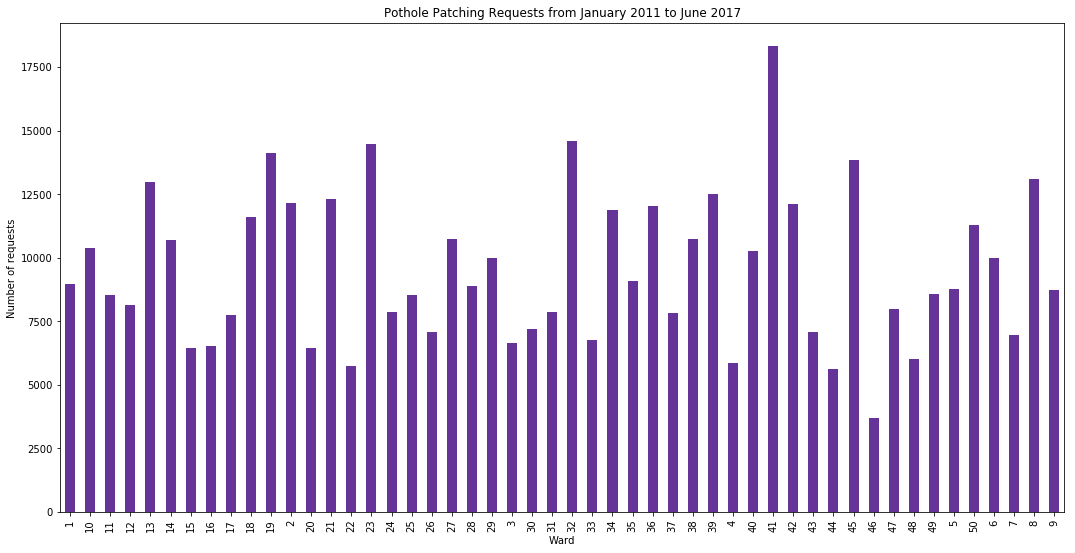

In [21]:
requests = df.groupby('Ward')['cleaned Creation Date'].count()
fig = plt.figure(figsize=(18, 9))
requests.plot(kind='bar', color = 'rebeccapurple');
plt.ylabel('Number of requests');
plt.title('Pothole Patching Requests from January 2011 to June 2017');

From the above bar chart, we can see that Ward 41 has significantly more potholes reported than other wards.  Ward 41 includes O'Hare airport, which could explain either a higher incidence of potholes due to heavy traffic.  

We can further explore this correlation by comparing to the City's Average Daily Traffic Count dataset, which provides an approximation to the actual number of vehicles passing through a given location on an average weekday.  However, as this dataset does not contain ward information--only address and latitude/longitude--attempting to group the traffic by ward boundaries would prove difficult.

Next, we'll explore how pothole reporting changes by season.

In [22]:
df.groupby('season')

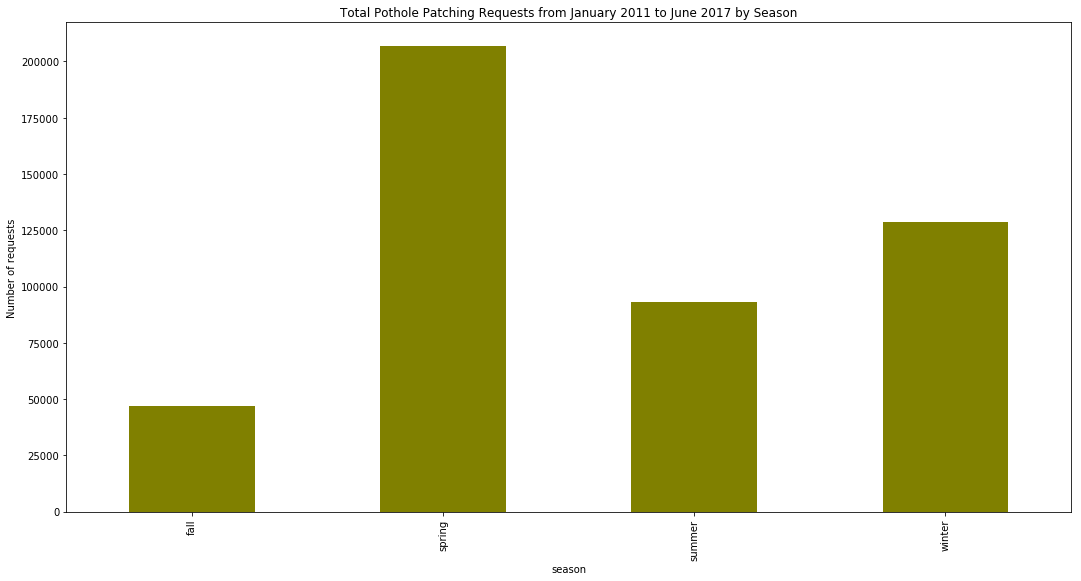

In [23]:
seasonalRequests = df.groupby('season')['cleaned Creation Date'].count()
fig = plt.figure(figsize=(18, 9))
seasonalRequests.plot(kind='bar', color = 'olive');
plt.ylabel('Number of requests');
plt.title('Total Pothole Patching Requests from January 2011 to June 2017 by Season');

The number of requests in the spring is significantly higher than the other three seasons.  Since more potholes are formed in the winter, requests could be more frequent in the spring after the winter season has done its damage.  Residents may be driving more in the spring than in the winter, resulting in more complaints to the DoT.

### Pothole reports over time

Now let's see how the frequency of pothole reporting has changed over time from 2011 to the present.

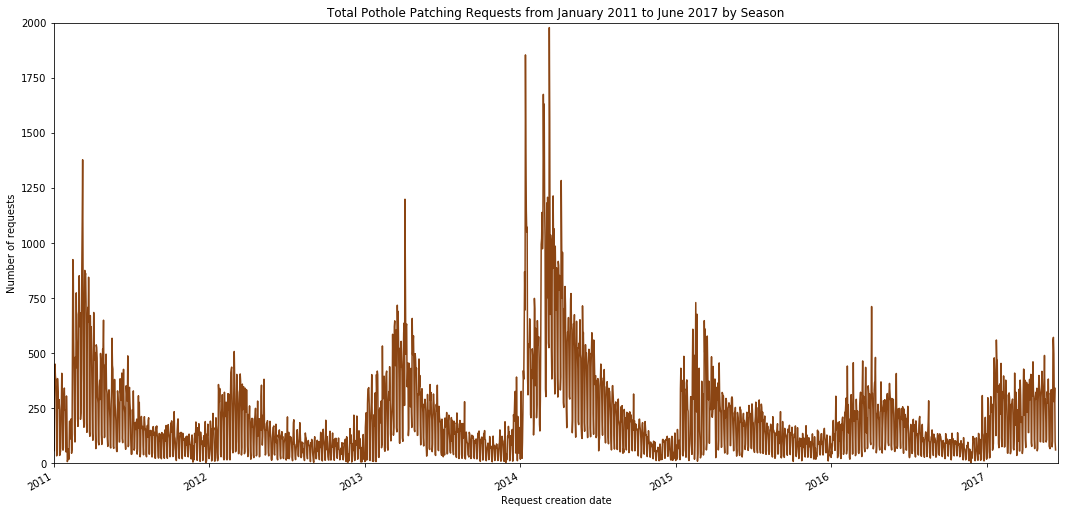

In [24]:
reportsOverTime = df.groupby('cleaned Creation Date')['cleaned Creation Date'].count()
fig = plt.figure(figsize=(18, 9))
reportsOverTime.plot(color = 'saddlebrown')
plt.xlim([datetime.datetime(2011, 1, 1, 0, 0), datetime.datetime(2017, 6, 17, 0, 0)])
plt.ylim([0,2000])
plt.ylabel('Number of requests')
plt.xlabel('Request creation date')
plt.title('Total Pothole Patching Requests from January 2011 to June 2017 by Season');

We see a dramatic spike in pothole requests in early 2014, which coincides with the infamous "polar vortex" that plunged temperatures in Chicago to record lows.  That winter also had the third-highest snowfall in Chicago history, leading to a lot of snow plowing and ultimately potholes.

### Number of potholes found by ward

Let's see how the average number of potholes found on the block compares by ward.

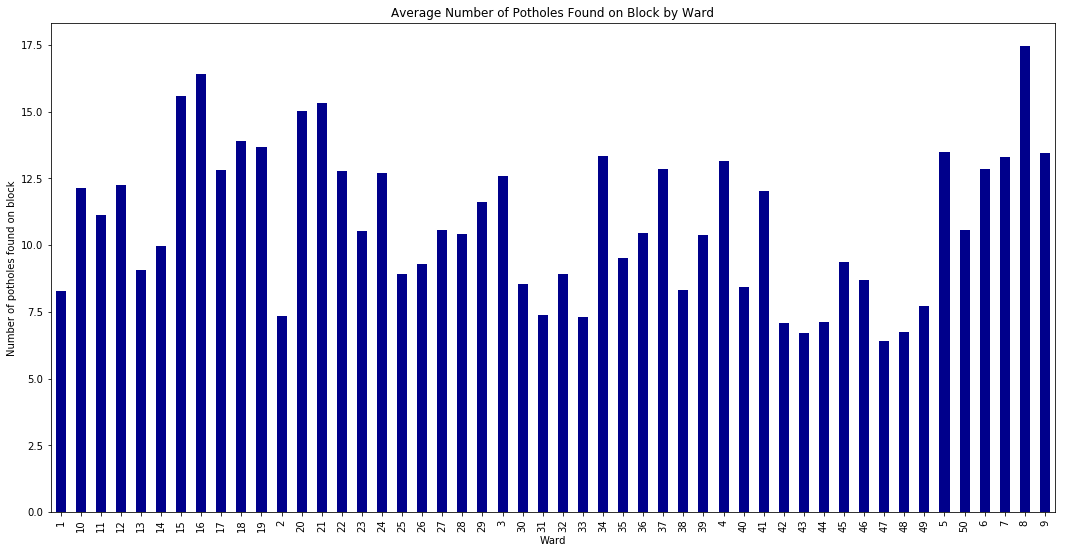

In [25]:
avgPotholes = df.groupby(['Ward', 'Direction'])['Num Potholes Filled On Block'].mean()

fig = plt.figure(figsize=(18, 9))
avgPotholes.plot(kind = 'bar', color = 'darkblue')
ax = plt.gca()
ax.set_xticklabels(avgDays.index.levels[0])
plt.xlabel('Ward')
plt.ylabel('Number of potholes found on block');
plt.title('Average Number of Potholes Found on Block by Ward');

Which wards have the highest average number of potholes found per block and which have the lowest?

In [26]:
#Sort the average number of potholes per block from low to high and take the bottom and top of that sorted series.
sortedAvgPotholes = avgPotholes.sort_values()
print('Five Wards with Most Potholes Per Block')
print(sortedAvgPotholes.tail())
print('')
print('Five Wards with Least Potholes Per Block')
print(sortedAvgPotholes.head())

Five Wards with Most Potholes Per Block
Ward  Direction
20    south        15.032916
21    south        15.320000
15    south        15.589221
16    south        16.423852
8     south        17.452517
Name: Num Potholes Filled On Block, dtype: float64

Five Wards with Least Potholes Per Block
Ward  Direction
47    north        6.395158
43    north        6.697189
48    north        6.730525
42    central      7.089133
44    north        7.101786
Name: Num Potholes Filled On Block, dtype: float64


All five wards with the most potholes found per block are on the south side, while all five with the least are either downtown or on the north side.  Let's compare how response time is related to the number of potholes found by the DoT on each block.

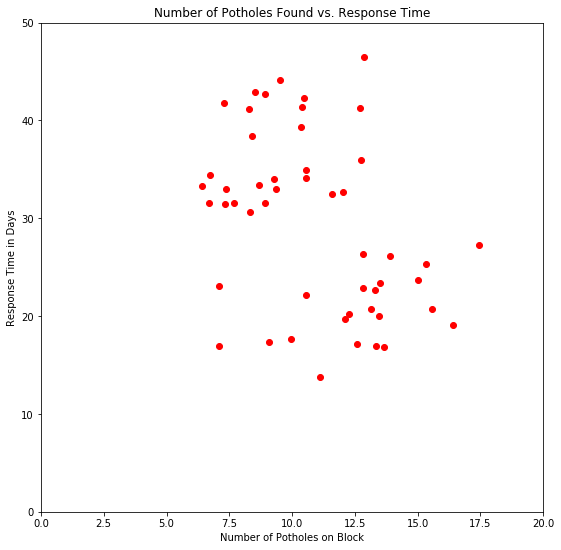

In [27]:
#Combine number of potholes per block and response time by ward
potholeNum = pd.Series(avgPotholes, name = 'Number of Potholes')
waitTime = pd.Series(avgDays, name = 'Response Time')
corr = pd.concat([potholeNum, waitTime], axis = 1)

fig = plt.figure(figsize=(9, 9))
plt.plot(corr['Number of Potholes'], corr['Response Time'], 'ro');
plt.xlabel('Number of Potholes on Block');
plt.ylabel('Response Time in Days');
plt.xlim([0,20]);
plt.ylim([0,50]);
plt.title('Number of Potholes Found vs. Response Time');

One might expect more potholes to be found after a longer wait time for a request to be serviced (giving potholes more time to appear) but from the scatterplot above, that does not seem to be the case.  No clear correlation exists between response time and number of potholes found on the block.

# Pulling in Census Data

A better way to cluster the data is by community area.  Unlike Chicago's wards, the community area boundaries were established in the 1920's according to established neighborhood lines and haven't changed since.  A 76th community area was added to the original 75 in 1953 to include O'Hare Airport, and the final 77th area was created when Edgewater split from Uptown in 1980.  These community areas were defined to track population and economic data over time and census tracts generally lie neatly within the area boundaries to allow easy data aggregation.

CMAP (Chicago Metropolitan Agency for Planning) has compiled data by community area from the U.S. Census Bureau's 2010-14 American Community Survey, Longitudinal Employment-Household Dynamics data for 2014, and 2014/2015 data from the Illinois Department of Employment Security and the Illinois Department of Revenue.

In [32]:
censusDF = pd.read_csv('ReferenceCCA20102014.csv')
censusDF

,GEOG,2000_POP,2010_POP,POP_CHANGE,TOT_POP,UND19,A20_34,A35_49,A50_64,A65_79,...,IND,INDperc,TRANS,TRANSperc,AG,Agperc,OPEN,OPENperc,VACANT,VACperc
0,Albany Park,57655,51542,-6113,52930,14351,14417,11908,8016,3062,...,19.929938,1.621420,414.736812,33.741335,0.000000,0.000000,25.293181,2.057752,6.672887,0.542880
1,Archer Heights,12644,13393,749,13971,4319,3277,2876,2058,1020,...,344.677590,26.848038,558.599207,43.511076,0.000000,0.000000,12.295439,0.957731,32.517216,2.532870
2,Armour Square,12032,13391,1359,13907,3037,3206,2434,2651,1639,...,18.046053,2.831079,343.648391,53.911829,0.000000,0.000000,15.019249,2.356231,14.366379,2.253809
3,Ashburn,39584,41081,1497,42809,12553,8473,8808,8724,3201,...,104.574805,3.362800,1064.249375,34.222945,0.000000,0.000000,259.867667,8.356535,83.385680,2.681424
4,Auburn Gresham,55928,48743,-7185,47611,13305,9014,8262,9515,5541,...,57.729492,2.393450,834.435659,34.595488,0.000000,0.000000,59.011603,2.446606,119.183176,4.941304
5,Austin,117527,98514,-19013,99711,30407,20747,18665,18300,9178,...,502.844219,10.992896,1464.868582,32.024128,0.000000,0.000000,199.702096,4.365774,169.487971,3.705250
6,Avalon Park,11147,10185,-962,10071,2066,2044,1669,2262,1510,...,12.597880,1.574515,316.768990,39.590583,0.000000,0.000000,28.048186,3.505533,21.171666,2.646088
7,Avondale,43083,39262,-3821,39117,9565,12319,8099,5726,2721,...,135.184040,10.650262,478.856580,37.725962,0.000000,0.000000,8.819135,0.694802,13.896510,1.094815
8,Belmont Cragin,78144,78743,599,79022,25902,18259,17142,11561,4606,...,132.786209,5.301719,775.701983,30.971242,0.000000,0.000000,64.475527,2.574297,9.427057,0.376392
9,Beverly,21992,20034,-1958,21002,5675,2967,4491,5111,2124,...,0.000000,0.000000,548.955181,26.934629,0.000000,0.000000,257.979765,12.657844,7.815703,0.383479


In [35]:
list(censusDF.columns)

['GEOG',
 '2000_POP',
 '2010_POP',
 'POP_CHANGE',
 'TOT_POP',
 'UND19',
 'A20_34',
 'A35_49',
 'A50_64',
 'A65_79',
 'OV80',
 'MED_AGE',
 'WHITE',
 'HISP',
 'BLACK',
 'ASIAN',
 'OTHER',
 'POP_HH',
 'POP_16OV',
 'IN_LBFRC',
 'EMP',
 'UNEMP',
 'NOT_IN_LBFRC',
 'WORK_AT_HOME',
 'TOT_COMM',
 'DROVE_AL',
 'CARPOOL',
 'TRANSIT',
 'WALK_BIKE',
 'COMM_OTHER',
 'POP_25OV',
 'HS',
 'BACH',
 'INC_LT_25K',
 'INC_25_50K',
 'INC_50_75K',
 'INC_75_100K',
 'INC_100_150K',
 'INC_GT_150',
 'MEDINC',
 'TOT_HH',
 'OWN_OCC_HU',
 'RENT_OCC_HU',
 'VAC_HU',
 'HU_TOT',
 'HU_SNG_DET',
 'HU_SNG_ATT',
 'HU_2UN',
 'HU_3_4UN',
 'HU_GT_5UN',
 'MED_ROOMS',
 'HA_AFT2000',
 'HA_70_00',
 'HA_40_70',
 'HA_BEF1940',
 'MED_HA',
 'BR_0_1',
 'BR_2',
 'BR_3',
 'BR_4',
 'BR_5',
 'HV_LT_150K',
 'HV_150_300K',
 'HV_300_500K',
 'HV_GT_500K',
 'MED_HV',
 'TOT_EMP_RES',
 'RES_NAICS1_TYPE',
 'RES_NAICS2_TYPE',
 'RES_NAICS3_TYPE',
 'RES_NAICS4_TYPE',
 'RES_NAICS5_TYPE',
 'RES_NAICS1_COUNT',
 'RES_NAICS2_COUNT',
 'RES_NAICS3_COUNT',
 

We need to create a key that will link the numeric community areas in the pothole data to the names included in the census datafile.

In [39]:
numbers = ['8','32','33','5','6','7','21','22','1','2','3','4','9','10','11','12','13','14','76','77','15','16','17','18','19','20','23','24','25','26','27','28','29','30','31','34','35','36','37','38','39','40','41','42','43','60','69','56','57','58','59','61','62','63','64','65','66','67','68','44','45','46','47','48','49','50','51','52','53','54','55','70','71','72','73','74','75']
names = ['Near North Side','Loop','Near South Side','North Center','Lake View','Lincoln Park','Avondale','Logan Square','Rogers Park','West Ridge','Uptown','Lincoln Square','Edison Park','Norwood Park','Jefferson Park','Forest Glen','North Park','Albany Park','O\'Hare','Edgewater','Portage Park','Irving Park','Dunning','Montclare','Belmont Cragin','Hermosa','Humboldt Park','West Town','Austin','West Garfield Park','East Garfield Park','Near West Side','North Lawndale','South Lawndale','Lower West Side','Armour Square','Douglas','Oakland','Fuller Park','Grand Boulevard','Kenwood','Washington Park','Hyde Park','Woodlawn','South Shore','Bridgeport','Greater Grand Crossing','Garfield Rdige','Archer Heights','Brighton Park','McKinley Park','New City','West Elsdon','Gage Park','Clearing','West Lawn','Chicago Lawn','West Englewood','Englewood','Chatham','Avalon Park','South Chicago','Burnside','Calumet Heights','Roseland','Pullman','South Deering','East Side','West Pullman','Riverdale','Hegewisch','Ashburn','Auburn Greshman','Beverly','Washington Heights','Mount Greenwood','Morgan Park']
regions = ['Central','Central','Central','North Side','North Side','North Side','North Side','North Side','Far North Side','Far North Side','Far North Side','Far North Side','Far North Side','Far North Side','Far North Side','Far North Side','Far North Side','Far North Side','Far North Side','Far North Side','Northwest Side','Northwest Side','Northwest Side','Northwest Side','Northwest Side','Northwest Side','West Side','West Side','West Side','West Side','West Side','West Side','West Side','West Side','West Side','South Side','South Side','South Side','South Side','South Side','South Side','South Side','South Side','South Side','South Side','South Side','South Side','Southwest Side','Southwest Side','Southwest Side','Southwest Side','Southwest Side','Southwest Side','Southwest Side','Southwest Side','Southwest Side','Southwest Side','Southwest Side','Southwest Side','Far Southeast Side','Far Southeast Side','Far Southeast Side','Far Southeast Side','Far Southeast Side','Far Southeast Side','Far Southeast Side','Far Southeast Side','Far Southeast Side','Far Southeast Side','Far Southeast Side','Far Southeast Side','Far Southwest Side','Far Southwest Side','Far Southwest Side','Far Southwest Side','Far Southwest Side','Far Southwest Side']

In [40]:
len(numbers), len(names), len(regions)

(77, 77, 77)

In [48]:
table = [numbers, names, regions]
CA_key = pd.DataFrame(table).transpose()
CA_key.columns = ['Community Area', 'GEOG', 'CA Region']
CA_key

,Community Area,GEOG,CA Region
0,8,Near North Side,Central
1,32,Loop,Central
2,33,Near South Side,Central
3,5,North Center,North Side
4,6,Lake View,North Side
5,7,Lincoln Park,North Side
6,21,Avondale,North Side
7,22,Logan Square,North Side
8,1,Rogers Park,Far North Side
9,2,West Ridge,Far North Side


In [49]:
censusDF_num = pd.merge(censusDF, CA_key, on='GEOG')
censusDF_num

,GEOG,2000_POP,2010_POP,POP_CHANGE,TOT_POP,UND19,A20_34,A35_49,A50_64,A65_79,...,TRANS,TRANSperc,AG,Agperc,OPEN,OPENperc,VACANT,VACperc,Community Area,CA Region
0,Albany Park,57655,51542,-6113,52930,14351,14417,11908,8016,3062,...,414.736812,33.741335,0.000000,0.000000,25.293181,2.057752,6.672887,0.542880,14,Far North Side
1,Archer Heights,12644,13393,749,13971,4319,3277,2876,2058,1020,...,558.599207,43.511076,0.000000,0.000000,12.295439,0.957731,32.517216,2.532870,57,Southwest Side
2,Armour Square,12032,13391,1359,13907,3037,3206,2434,2651,1639,...,343.648391,53.911829,0.000000,0.000000,15.019249,2.356231,14.366379,2.253809,34,South Side
3,Ashburn,39584,41081,1497,42809,12553,8473,8808,8724,3201,...,1064.249375,34.222945,0.000000,0.000000,259.867667,8.356535,83.385680,2.681424,70,Far Southwest Side
4,Austin,117527,98514,-19013,99711,30407,20747,18665,18300,9178,...,1464.868582,32.024128,0.000000,0.000000,199.702096,4.365774,169.487971,3.705250,25,West Side
5,Avalon Park,11147,10185,-962,10071,2066,2044,1669,2262,1510,...,316.768990,39.590583,0.000000,0.000000,28.048186,3.505533,21.171666,2.646088,45,Far Southeast Side
6,Avondale,43083,39262,-3821,39117,9565,12319,8099,5726,2721,...,478.856580,37.725962,0.000000,0.000000,8.819135,0.694802,13.896510,1.094815,21,North Side
7,Belmont Cragin,78144,78743,599,79022,25902,18259,17142,11561,4606,...,775.701983,30.971242,0.000000,0.000000,64.475527,2.574297,9.427057,0.376392,19,Northwest Side
8,Beverly,21992,20034,-1958,21002,5675,2967,4491,5111,2124,...,548.955181,26.934629,0.000000,0.000000,257.979765,12.657844,7.815703,0.383479,72,Far Southwest Side
9,Bridgeport,33694,31977,-1717,31882,6997,8656,6118,6825,2262,...,491.094071,36.698258,0.000000,0.000000,43.521513,3.252256,79.793982,5.962809,60,South Side


In [58]:
df = df[df['Community Area'].notnull()]

In [60]:
totalDF = pd.merge(df,censusDF_num, on='Community Area')
totalDF

,cleaned Creation Date,STATUS,cleaned Completion Date,SERVICE REQUEST NUMBER,TYPE OF SERVICE REQUEST,CURRENT ACTIVITY,MOST RECENT ACTION,Num Potholes Filled On Block,X Coordinate,Y Coordinate,...,INDperc,TRANS,TRANSperc,AG,Agperc,OPEN,OPENperc,VACANT,VACperc,CA Region
0,2011-01-01,Completed - Dup,2011-01-03,11-00002110,Pot Hole in Street,None,None,NaN,1.17386e+06,1.85451e+06,...,1.894833,991.703193,43.699579,0.00000,0.000000,33.559291,1.478796,130.322859,5.742700,South Side
1,2011-01-02,Completed,2011-01-03,11-00004006,Pot Hole in Street,Dispatch Crew,Pothole Patched,8.0,1.17428e+06,1.85453e+06,...,1.894833,991.703193,43.699579,0.00000,0.000000,33.559291,1.478796,130.322859,5.742700,South Side
2,2011-01-03,Completed,2011-01-07,11-00005371,Pot Hole in Street,Dispatch Crew,Pothole Patched,2.0,1.17461e+06,1.85453e+06,...,1.894833,991.703193,43.699579,0.00000,0.000000,33.559291,1.478796,130.322859,5.742700,South Side
3,2012-01-05,Completed,2012-01-05,12-00022727,Pot Hole in Street,Dispatch Crew,Pothole Patched,2.0,1.17547e+06,1.85437e+06,...,1.894833,991.703193,43.699579,0.00000,0.000000,33.559291,1.478796,130.322859,5.742700,South Side
4,2011-01-13,Completed,2011-01-13,11-00065016,Pot Hole in Street,Dispatch Crew,Pothole Patched,5.0,1.17599e+06,1.85258e+06,...,1.894833,991.703193,43.699579,0.00000,0.000000,33.559291,1.478796,130.322859,5.742700,South Side
5,2011-01-13,Completed,2011-01-13,11-00065031,Pot Hole in Street,Dispatch Crew,Pothole Patched,13.0,1.17466e+06,1.85254e+06,...,1.894833,991.703193,43.699579,0.00000,0.000000,33.559291,1.478796,130.322859,5.742700,South Side
6,2011-01-13,Completed,2011-01-13,11-00065035,Pot Hole in Street,Dispatch Crew,Pothole Patched,1.0,1.17466e+06,1.85278e+06,...,1.894833,991.703193,43.699579,0.00000,0.000000,33.559291,1.478796,130.322859,5.742700,South Side
7,2011-01-13,Completed,2011-01-19,11-00061872,Pot Hole in Street,Dispatch Crew,Pothole Patched,4.0,1.17554e+06,1.85456e+06,...,1.894833,991.703193,43.699579,0.00000,0.000000,33.559291,1.478796,130.322859,5.742700,South Side
8,2012-01-16,Completed,2012-01-19,12-00068376,Pot Hole in Street,Dispatch Crew,No Problem Found,0.0,1.17515e+06,1.85326e+06,...,1.894833,991.703193,43.699579,0.00000,0.000000,33.559291,1.478796,130.322859,5.742700,South Side
9,2011-01-18,Completed,2011-01-19,11-00080387,Pot Hole in Street,Dispatch Crew,Pothole Patched,30.0,1.1752e+06,1.85455e+06,...,1.894833,991.703193,43.699579,0.00000,0.000000,33.559291,1.478796,130.322859,5.742700,South Side


In [61]:
list(totalDF.columns)

['cleaned Creation Date',
 'STATUS',
 'cleaned Completion Date',
 'SERVICE REQUEST NUMBER',
 'TYPE OF SERVICE REQUEST',
 'CURRENT ACTIVITY',
 'MOST RECENT ACTION',
 'Num Potholes Filled On Block',
 'X Coordinate',
 'Y Coordinate',
 'Latitude',
 'Longitude',
 'STREET ADDRESS',
 'ZIP',
 'Ward',
 'Police District',
 'Community Area',
 'SSA',
 'Direction',
 'timePassed',
 'season',
 'GEOG',
 '2000_POP',
 '2010_POP',
 'POP_CHANGE',
 'TOT_POP',
 'UND19',
 'A20_34',
 'A35_49',
 'A50_64',
 'A65_79',
 'OV80',
 'MED_AGE',
 'WHITE',
 'HISP',
 'BLACK',
 'ASIAN',
 'OTHER',
 'POP_HH',
 'POP_16OV',
 'IN_LBFRC',
 'EMP',
 'UNEMP',
 'NOT_IN_LBFRC',
 'WORK_AT_HOME',
 'TOT_COMM',
 'DROVE_AL',
 'CARPOOL',
 'TRANSIT',
 'WALK_BIKE',
 'COMM_OTHER',
 'POP_25OV',
 'HS',
 'BACH',
 'INC_LT_25K',
 'INC_25_50K',
 'INC_50_75K',
 'INC_75_100K',
 'INC_100_150K',
 'INC_GT_150',
 'MEDINC',
 'TOT_HH',
 'OWN_OCC_HU',
 'RENT_OCC_HU',
 'VAC_HU',
 'HU_TOT',
 'HU_SNG_DET',
 'HU_SNG_ATT',
 'HU_2UN',
 'HU_3_4UN',
 'HU_GT_5UN',


### Pothole requests by region

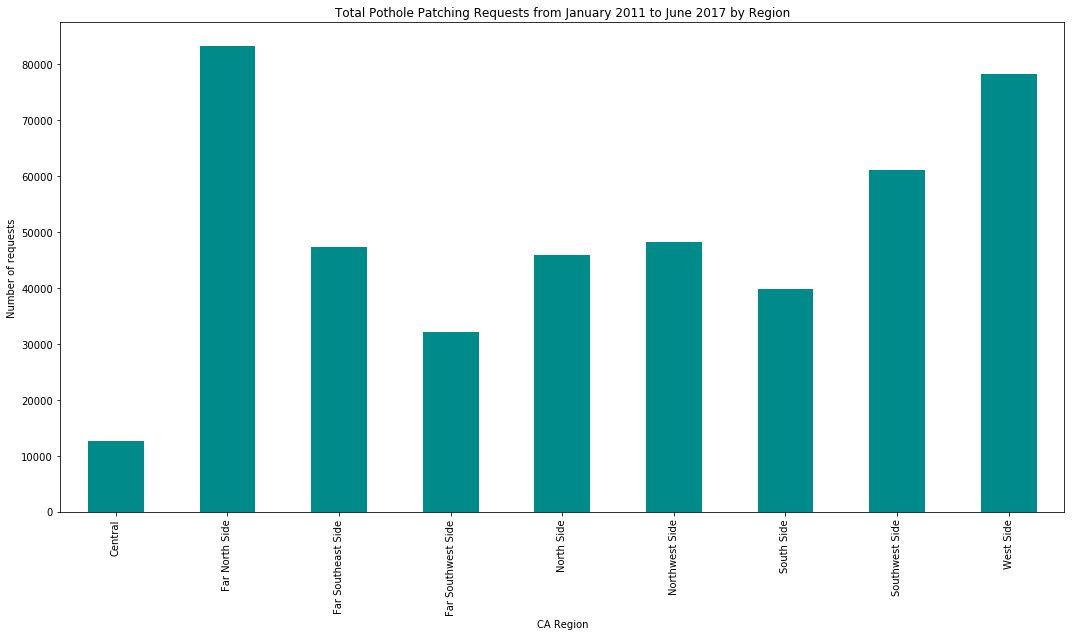

In [65]:
regionalRequests = totalDF.groupby('CA Region')['cleaned Creation Date'].count()
fig = plt.figure(figsize=(18, 9))
regionalRequests.plot(kind='bar', color = 'darkcyan');
plt.ylabel('Number of requests');
plt.title('Total Pothole Patching Requests from January 2011 to June 2017 by Region');

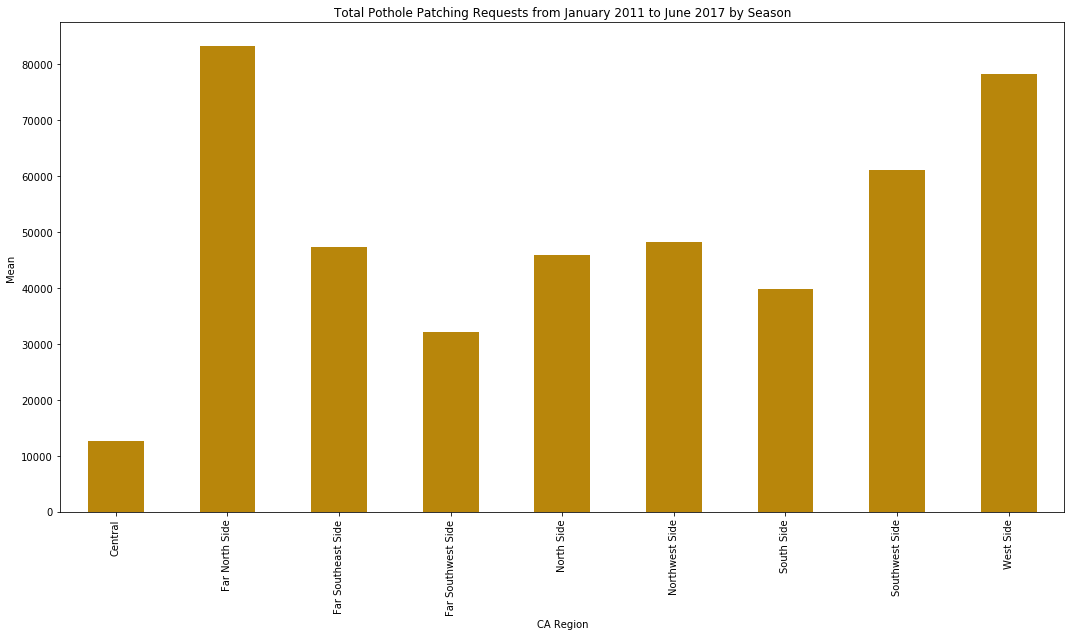

In [68]:
regionalPop = totalDF.groupby('CA Region')['TOT_POP'].count()
fig = plt.figure(figsize=(18, 9))
regionalPop.plot(kind='bar', color = 'darkgoldenrod');
plt.ylabel('Mean ');
plt.title('Total Pothole Patching Requests from January 2011 to June 2017 by Season');